<a href="https://colab.research.google.com/github/kishan4935/prediction-of-multiple-sclerosis-diseases/blob/main/prediction_of_multiple_sclerosis_diseases_75.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install eli5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107717 sha256=1a2862fbae0d6e0bf80f767b9c0c7e1fd33db9cd9e66f12fdbd60fb9aec6b54b
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [3]:
pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.0 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
#from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [7]:
data = pd.read_csv("/content/conversion_predictors_of_clinically_isolated_syndrome_to_multiple_sclerosis.csv")
data.head()

,Unnamed: 0,Gender,Age,Schooling,Breastfeeding,Varicella,Initial_Symptom,Mono_or_Polysymptomatic,Oligoclonal_Bands,LLSSEP,ULSSEP,VEP,BAEP,Periventricular_MRI,Cortical_MRI,Infratentorial_MRI,Spinal_Cord_MRI,Initial_EDSS,Final_EDSS,group
0,0,1,34,20.0,1,1,2.0,1,0,1,1,0,0,0,1,0,1,1.0,1.0,1
1,1,1,61,25.0,3,2,10.0,2,1,1,0,1,0,0,0,0,1,2.0,2.0,1
2,2,1,22,20.0,3,1,3.0,1,1,0,0,0,0,0,1,0,0,1.0,1.0,1
3,3,2,41,15.0,1,1,7.0,2,1,0,1,1,0,1,1,0,0,1.0,1.0,1
4,4,2,34,20.0,2,1,6.0,2,0,1,0,0,0,1,0,0,0,1.0,1.0,1


In [8]:
data.shape

(273, 20)

In [9]:
data.describe()

,Unnamed: 0,Gender,Age,Schooling,Breastfeeding,Varicella,Initial_Symptom,Mono_or_Polysymptomatic,Oligoclonal_Bands,LLSSEP,ULSSEP,VEP,BAEP,Periventricular_MRI,Cortical_MRI,Infratentorial_MRI,Spinal_Cord_MRI,Initial_EDSS,Final_EDSS,group
count,273.000000,273.000000,273.000000,272.000000,273.000000,273.000000,272.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,125.000000,125.00000,273.000000
mean,136.000000,1.615385,34.062271,15.176471,1.831502,1.710623,6.430147,1.725275,0.358974,0.424908,0.369963,0.307692,0.065934,0.505495,0.432234,0.293040,0.315018,1.360000,1.44800,1.542125
std,78.952517,0.487398,11.114369,4.244175,0.874998,0.732991,4.222009,0.494066,0.558426,0.495237,0.483681,0.462386,0.248623,0.500888,0.496296,0.455993,0.465376,0.587504,0.65323,0.499137
min,0.000000,1.000000,15.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,1.000000
25%,68.000000,1.000000,25.000000,12.000000,1.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,1.000000
50%,136.000000,2.000000,33.000000,15.000000,2.000000,2.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.00000,2.000000
75%,204.000000,2.000000,40.000000,20.000000,3.000000,2.000000,9.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.00000,2.000000
max,272.000000,2.000000,77.000000,25.000000,3.000000,3.000000,15.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.00000,2.000000


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               273 non-null    int64  
 1   Gender                   273 non-null    int64  
 2   Age                      273 non-null    int64  
 3   Schooling                272 non-null    float64
 4   Breastfeeding            273 non-null    int64  
 5   Varicella                273 non-null    int64  
 6   Initial_Symptom          272 non-null    float64
 7   Mono_or_Polysymptomatic  273 non-null    int64  
 8   Oligoclonal_Bands        273 non-null    int64  
 9   LLSSEP                   273 non-null    int64  
 10  ULSSEP                   273 non-null    int64  
 11  VEP                      273 non-null    int64  
 12  BAEP                     273 non-null    int64  
 13  Periventricular_MRI      273 non-null    int64  
 14  Cortical_MRI             2

In [11]:
data = data.drop('Unnamed: 0', axis=1)

#### Missing values
* 'Schooling' and 'Initial_Symptom' have only one missing value
* 'Initial_EDSS' and 'Final_EDSS" have 148 missing values while is more than 50% of the data. Thus we will drop these columns

In [12]:
data.isnull().sum()

Gender                       0
Age                          0
Schooling                    1
Breastfeeding                0
Varicella                    0
Initial_Symptom              1
Mono_or_Polysymptomatic      0
Oligoclonal_Bands            0
LLSSEP                       0
ULSSEP                       0
VEP                          0
BAEP                         0
Periventricular_MRI          0
Cortical_MRI                 0
Infratentorial_MRI           0
Spinal_Cord_MRI              0
Initial_EDSS               148
Final_EDSS                 148
group                        0
dtype: int64

In [13]:
data = data.drop(['Initial_EDSS', 'Final_EDSS'], axis=1)
data = data.fillna(data.mean(), axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   273 non-null    int64  
 1   Age                      273 non-null    int64  
 2   Schooling                273 non-null    float64
 3   Breastfeeding            273 non-null    int64  
 4   Varicella                273 non-null    int64  
 5   Initial_Symptom          273 non-null    float64
 6   Mono_or_Polysymptomatic  273 non-null    int64  
 7   Oligoclonal_Bands        273 non-null    int64  
 8   LLSSEP                   273 non-null    int64  
 9   ULSSEP                   273 non-null    int64  
 10  VEP                      273 non-null    int64  
 11  BAEP                     273 non-null    int64  
 12  Periventricular_MRI      273 non-null    int64  
 13  Cortical_MRI             273 non-null    int64  
 14  Infratentorial_MRI       2

In [14]:
df = data.copy()

In [15]:
gender = {1:'Male', 2: 'Female'}
breastfeeding = {1: 'yes', 2:'no', 3:'unknown'}
varicella = {1 : 'positive', 2: 'negative', 3: 'unknown'}
group = {1: 'CDMS' , 2: 'Non-CDMS' }

In [16]:
data['Gender'] = data['Gender'].map(gender)
data['Breastfeeding'] = data['Breastfeeding'].map(breastfeeding)
data['Varicella'] = data['Varicella'].map(varicella)
data['group'] = data['group'].map(group)

In [17]:
data.head()

,Gender,Age,Schooling,Breastfeeding,Varicella,Initial_Symptom,Mono_or_Polysymptomatic,Oligoclonal_Bands,LLSSEP,ULSSEP,VEP,BAEP,Periventricular_MRI,Cortical_MRI,Infratentorial_MRI,Spinal_Cord_MRI,group
0,Male,34,20.0,yes,positive,2.0,1,0,1,1,0,0,0,1,0,1,CDMS
1,Male,61,25.0,unknown,negative,10.0,2,1,1,0,1,0,0,0,0,1,CDMS
2,Male,22,20.0,unknown,positive,3.0,1,1,0,0,0,0,0,1,0,0,CDMS
3,Female,41,15.0,yes,positive,7.0,2,1,0,1,1,0,1,1,0,0,CDMS
4,Female,34,20.0,no,positive,6.0,2,0,1,0,0,0,1,0,0,0,CDMS


## EDA
Let's start to understant the data

#### Correlation HeatMap
From the heatmap we see that only 'Initial_Symptom', 'Periventricular_MRI' and 'Infratentorial_MRI' are the only variables that have a strong correrlation with the target group i.e group

<Axes: >

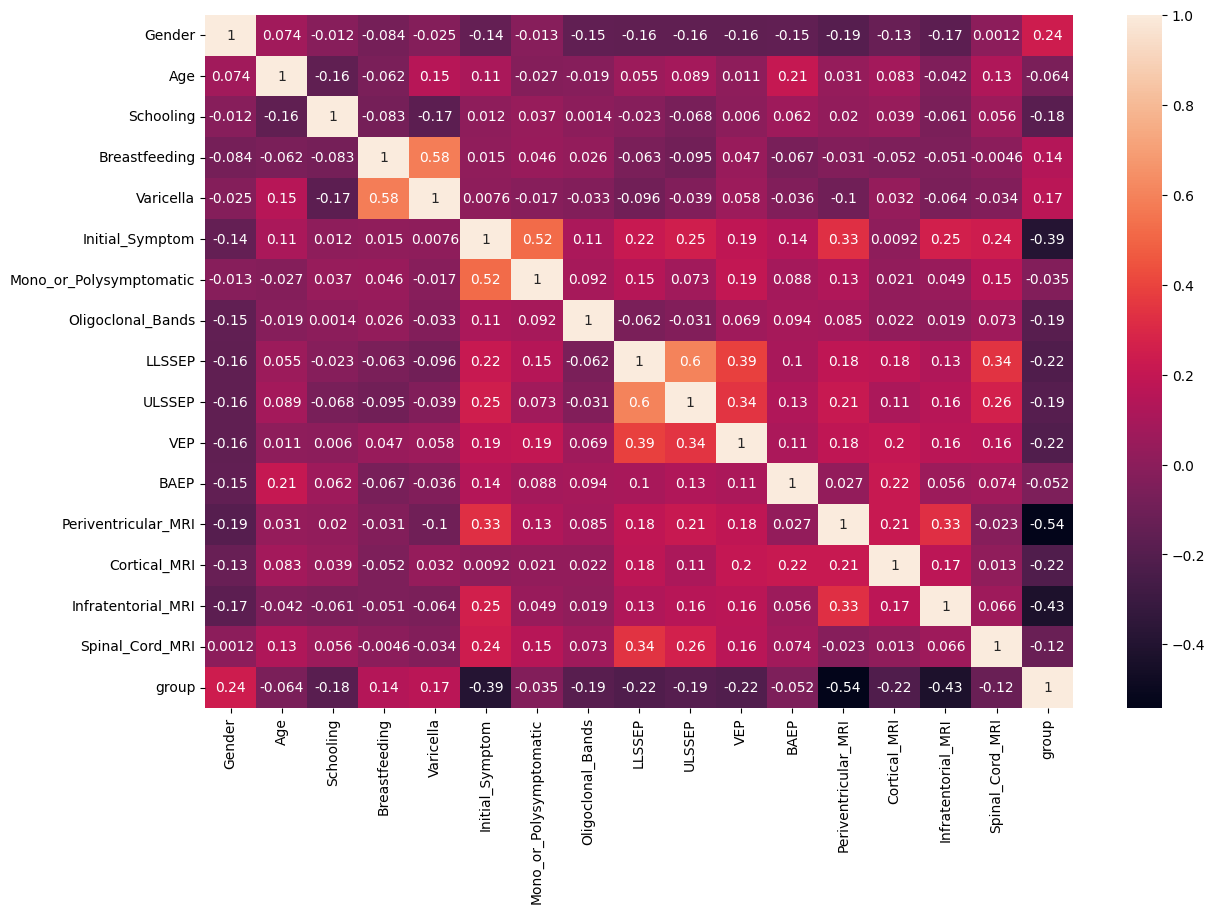

In [18]:
corr = df.corr()
plt.figure(figsize=(14, 9))
sns.heatmap(corr, annot=True)

#### Target Distribution
The target distribution is ~46% (CDMS) to ~54%(Non-CDMS). So target is fairly balanced.

([<matplotlib.patches.Wedge at 0x7928b0926a40>,
 [Text(-0.14514752300736714, 1.0903816747198323, 'Non-CDMS'),
  Text(0.14514762509626647, -1.0903816611301356, 'CDMS')],
 [Text(-0.07917137618583661, 0.5947536407562721, '54.21'),
  Text(0.07917143187069078, -0.5947536333437102, '45.79')])

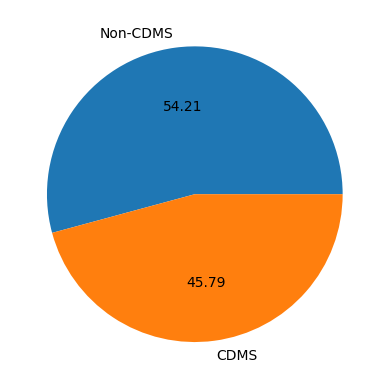

In [19]:
a = data['group'].value_counts()
plt.pie(a.values, labels = a.index, autopct='%.2f')

#### Numeric Data
In the data only 'Age' and 'Schooling' are numeric in nature

##### Age
* The 'Age' of people don't seem to affect the likelihood of a positive CDMS diagnoses.

Text(0.5, 0, 'Age (years)')

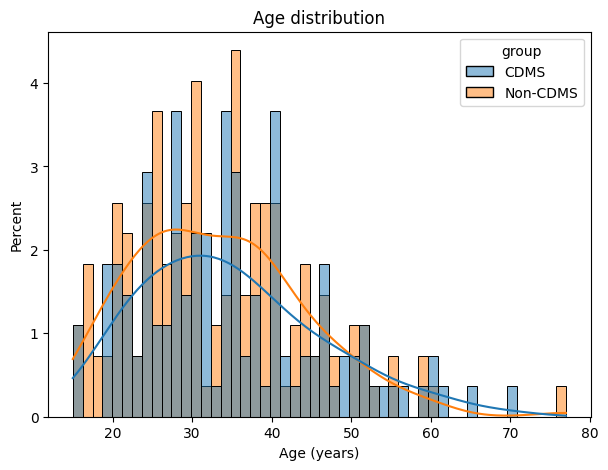

In [20]:
plt.figure(figsize = (7,5))
sns.histplot(data=data, x='Age', hue='group', stat='percent', common_norm=True, kde=True, bins=50)
plt.title('Age distribution')
plt.xlabel('Age (years)')

Text(0.5, 0, 'Schooling (years)')

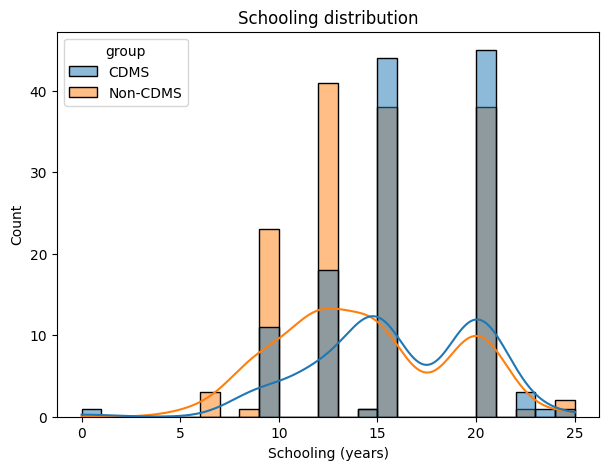

In [21]:
plt.figure(figsize = (7,5))
sns.histplot(data=data, x='Schooling', hue='group', binwidth=1, kde=True)
plt.title('Schooling distribution')
plt.xlabel('Schooling (years)')

In [22]:
data['Schooling'].describe()

count    273.000000
mean      15.176471
std        4.236366
min        0.000000
25%       12.000000
50%       15.000000
75%       20.000000
max       25.000000
Name: Schooling, dtype: float64

In [23]:
data['Schooling'].value_counts()

20.000000    83
15.000000    81
12.000000    59
9.000000     34
22.000000     4
6.000000      3
25.000000     2
14.000000     2
0.000000      1
23.000000     1
15.176471     1
24.000000     1
8.000000      1
Name: Schooling, dtype: int64

#### Categorical Data

In [24]:
def count_plot(data, feature, title, hue=True):
    plt.figure(figsize=(7, 5))
    total = float(len(data))
    if hue:
        ax = sns.countplot(x=data[feature], hue=data['group'])
    else:
        ax = sns.countplot(x=data[feature], hue=None)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.1f} %'.format((height/total)*100), ha="center",
               bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

    ax.set_title(title, fontsize=16, y=1.05)
    sns.despine(right=True)
    sns.despine(offset=5, trim=True)

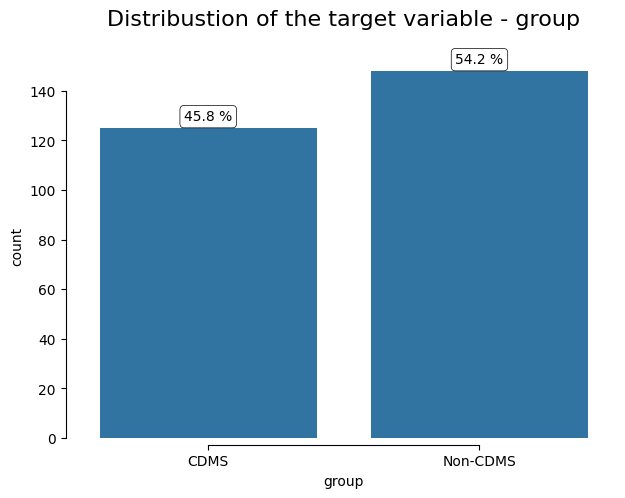

In [25]:
count_plot(data, 'group', 'Distribustion of the target variable - group', hue=False)

##### Gender
* The male to female ratio of patients is approximately 38% to 62%.
* However, 61% of the male patients are diagnosed with CDMS.

##### Varicella
* 45% of the patients have been tested for Varicella and about 17% of them have unknown cases.
* However, it appears that being positve for Varicella does not increase the likelihood of a positive CDMS diagnoses.

##### Four MRI's
* The dataset contents four MRI test of the patients, Periventricular_MRI, Infratentorial_MRI, Spinal_Cord_MRI and Cortical_MRI.
* Infratentorial_MRI test comes first in terms of CDMS converion with 78.8% followed by Periventricular_MRI with 72.5%.
* Whereas Cortical_MRI and Spinal_Cord_MRI's conversion probabilities are 58.5% and 54.6% respectively.

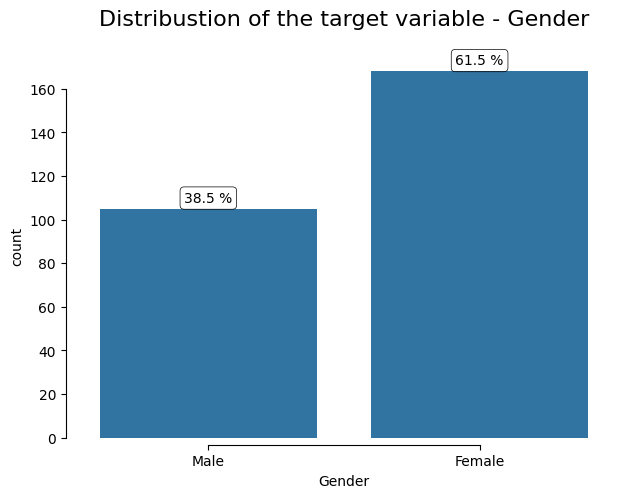

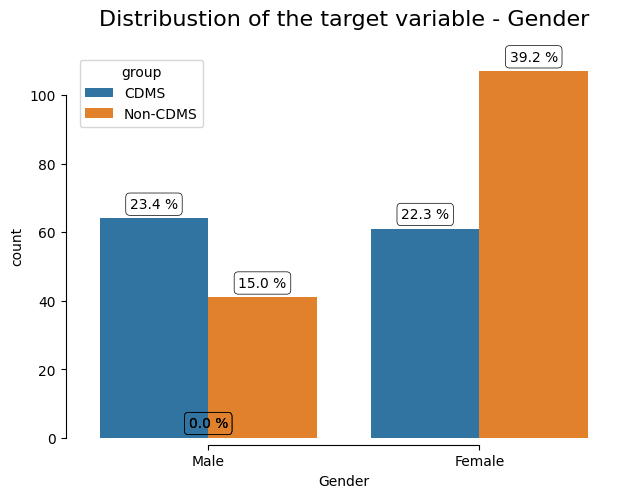

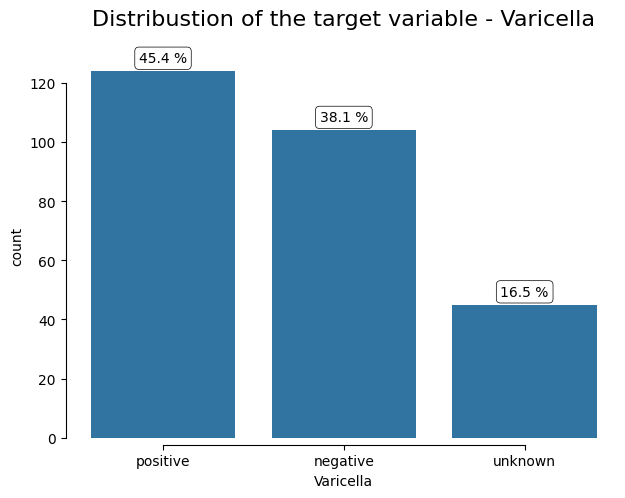

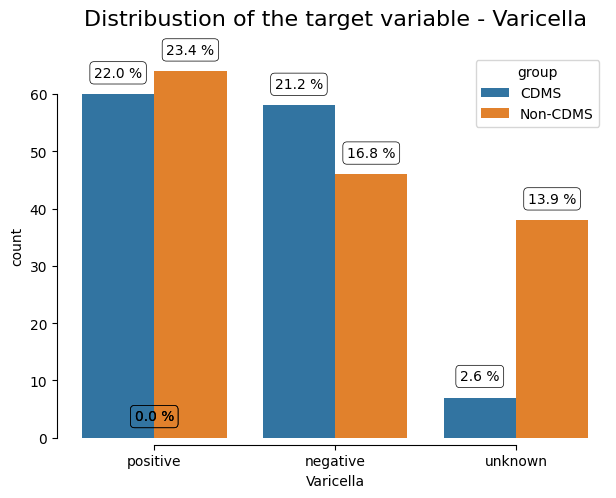

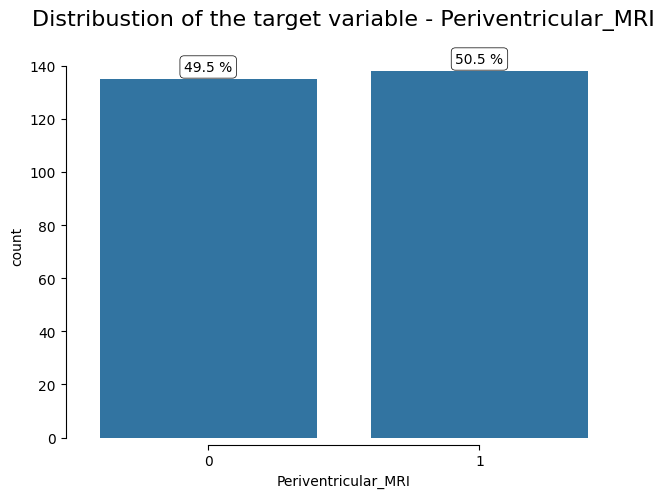

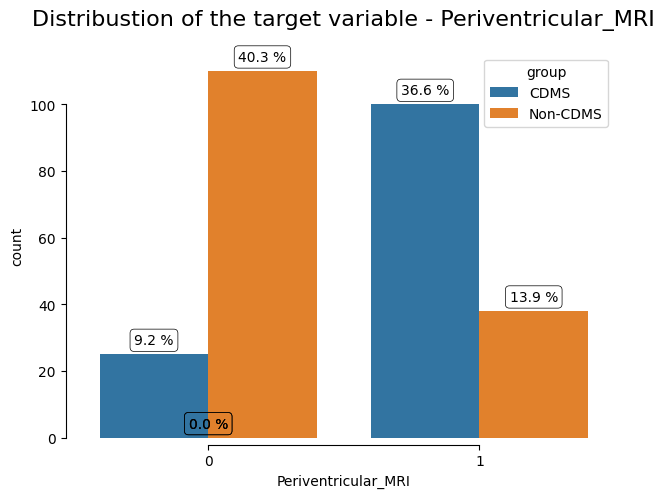

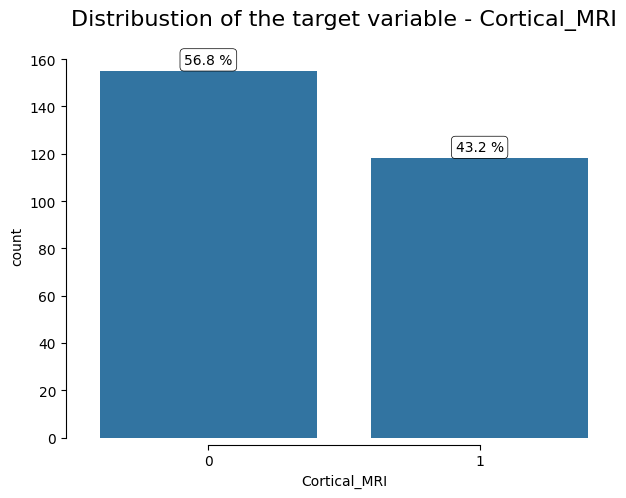

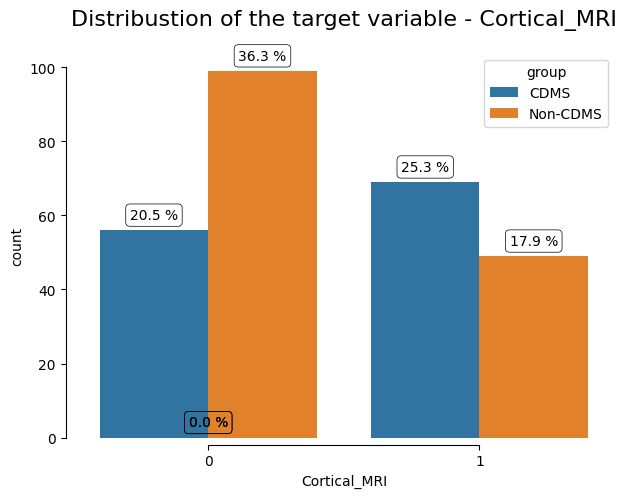

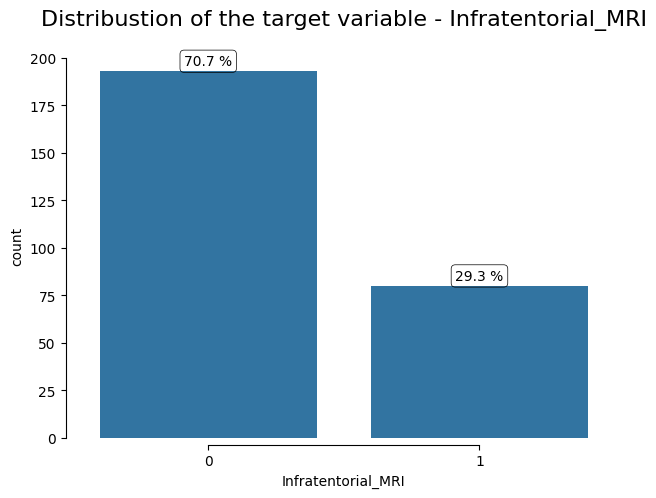

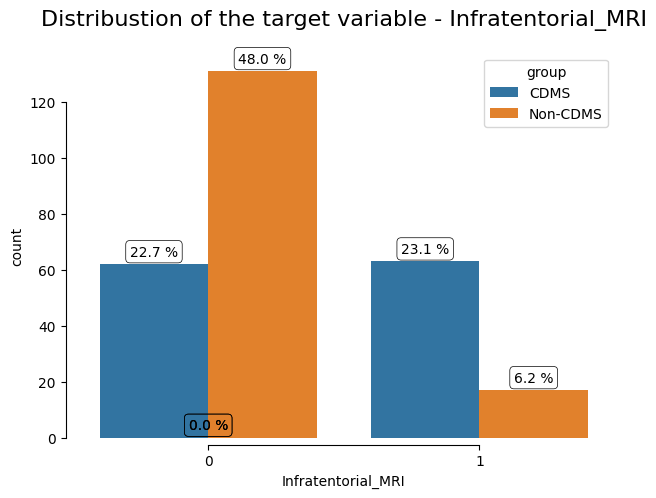

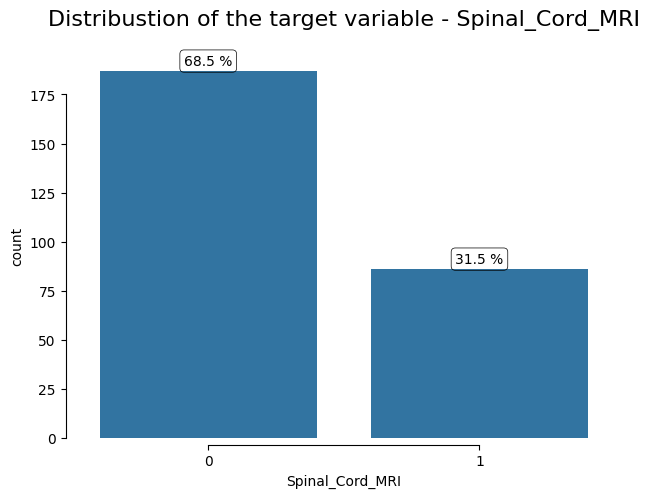

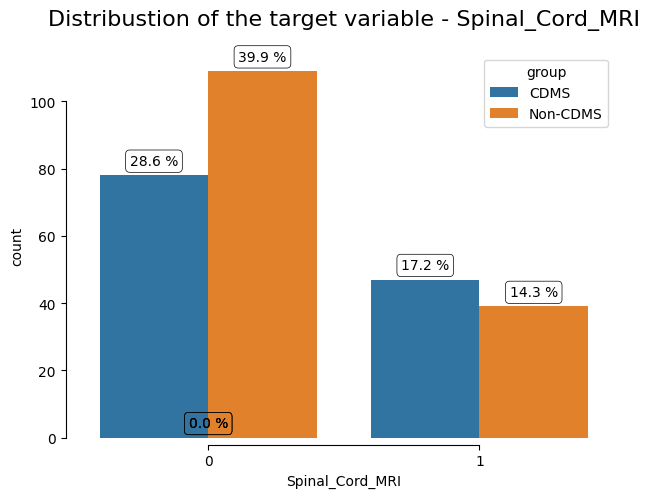

In [26]:
col = ['Gender', 'Varicella','Periventricular_MRI', 'Cortical_MRI', 'Infratentorial_MRI', 'Spinal_Cord_MRI']
for i in col:
    count_plot(data, i, 'Distribustion of the target variable - '+i, hue=0)
    count_plot(data, i, 'Distribustion of the target variable - '+i, hue=1)

In [27]:
col = ['Periventricular_MRI', 'Cortical_MRI', 'Infratentorial_MRI', 'Spinal_Cord_MRI']
for i in col:
    print("Percecntage for " + i)
    print()
    print(data.groupby([i])['group'].value_counts(normalize=True).mul(100))
    print()
    print("-----------------------------------")
    print()

Percecntage for Periventricular_MRI

Periventricular_MRI  group   
0                    Non-CDMS    81.481481
                     CDMS        18.518519
1                    CDMS        72.463768
                     Non-CDMS    27.536232
Name: group, dtype: float64

-----------------------------------

Percecntage for Cortical_MRI

Cortical_MRI  group   
0             Non-CDMS    63.870968
              CDMS        36.129032
1             CDMS        58.474576
              Non-CDMS    41.525424
Name: group, dtype: float64

-----------------------------------

Percecntage for Infratentorial_MRI

Infratentorial_MRI  group   
0                   Non-CDMS    67.875648
                    CDMS        32.124352
1                   CDMS        78.750000
                    Non-CDMS    21.250000
Name: group, dtype: float64

-----------------------------------

Percecntage for Spinal_Cord_MRI

Spinal_Cord_MRI  group   
0                Non-CDMS    58.288770
                 CDMS        41.711

* Looknig at this table we can say that their is an 80% chance of positive CDMS if all four MRI are positive

In [28]:
 print(data.groupby(col)['group'].value_counts(normalize=True).mul(100))

Periventricular_MRI  Cortical_MRI  Infratentorial_MRI  Spinal_Cord_MRI  group   
0                    0             0                   0                Non-CDMS     96.363636
                                                                        CDMS          3.636364
                                                       1                Non-CDMS     79.166667
                                                                        CDMS         20.833333
                                   1                   0                Non-CDMS     75.000000
                                                                        CDMS         25.000000
                                                       1                CDMS         75.000000
                                                                        Non-CDMS     25.000000
                     1             0                   0                Non-CDMS     82.608696
                                                                

In [29]:
col = ['LLSSEP','ULSSEP', 'VEP', 'BAEP']
for i in col:
    print("Percecntage for " + i)
    print()
    print(data.groupby([i])['group'].value_counts(normalize=True).mul(100))
    print()
    print("-----------------------------------")
    print()

Percecntage for LLSSEP

LLSSEP  group   
0       Non-CDMS    63.694268
        CDMS        36.305732
1       CDMS        58.620690
        Non-CDMS    41.379310
Name: group, dtype: float64

-----------------------------------

Percecntage for ULSSEP

ULSSEP  group   
0       Non-CDMS    61.627907
        CDMS        38.372093
1       CDMS        58.415842
        Non-CDMS    41.584158
Name: group, dtype: float64

-----------------------------------

Percecntage for VEP

VEP  group   
0    Non-CDMS    61.375661
     CDMS        38.624339
1    CDMS        61.904762
     Non-CDMS    38.095238
Name: group, dtype: float64

-----------------------------------

Percecntage for BAEP

BAEP  group   
0     Non-CDMS    54.901961
      CDMS        45.098039
1     CDMS        55.555556
      Non-CDMS    44.444444
Name: group, dtype: float64

-----------------------------------



* Similarly, it seams that their is 80% chance of positive CDMS if all four Potentials scales are positive

In [30]:
print(data.groupby(col)['group'].value_counts(normalize=True).mul(100))

LLSSEP  ULSSEP  VEP  BAEP  group   
0       0       0    0     Non-CDMS     66.666667
                           CDMS         33.333333
                     1     Non-CDMS     66.666667
                           CDMS         33.333333
                1    0     Non-CDMS     64.285714
                           CDMS         35.714286
                     1     CDMS        100.000000
        1       0    0     Non-CDMS     62.500000
                           CDMS         37.500000
                     1     CDMS        100.000000
                1    0     CDMS         62.500000
                           Non-CDMS     37.500000
                     1     Non-CDMS    100.000000
1       0       0    0     CDMS         62.500000
                           Non-CDMS     37.500000
                     1     Non-CDMS    100.000000
                1    0     CDMS         60.000000
                           Non-CDMS     40.000000
                     1     Non-CDMS    100.000000
        1     

## Feature Selection and Pre-Processing
* From the above observations we say that we will only take 'Gender', 'Varicella', 'Initial_Symptom', 'LLSSEP','ULSSEP', 'VEP', 'BAEP', 'Periventricular_MRI', 'Cortical_MRI', 'Infratentorial_MRI', 'Spinal_Cord_MRI', and 'group' to work in the future.

In [31]:
df.head()

,Gender,Age,Schooling,Breastfeeding,Varicella,Initial_Symptom,Mono_or_Polysymptomatic,Oligoclonal_Bands,LLSSEP,ULSSEP,VEP,BAEP,Periventricular_MRI,Cortical_MRI,Infratentorial_MRI,Spinal_Cord_MRI,group
0,1,34,20.0,1,1,2.0,1,0,1,1,0,0,0,1,0,1,1
1,1,61,25.0,3,2,10.0,2,1,1,0,1,0,0,0,0,1,1
2,1,22,20.0,3,1,3.0,1,1,0,0,0,0,0,1,0,0,1
3,2,41,15.0,1,1,7.0,2,1,0,1,1,0,1,1,0,0,1
4,2,34,20.0,2,1,6.0,2,0,1,0,0,0,1,0,0,0,1


In [32]:
col = ['Gender', 'Varicella', 'Initial_Symptom', 'LLSSEP','ULSSEP', 'VEP', 'BAEP', 'Periventricular_MRI', 'Cortical_MRI', 'Infratentorial_MRI', 'Spinal_Cord_MRI']
X = df[col]
X.head()

,Gender,Varicella,Initial_Symptom,LLSSEP,ULSSEP,VEP,BAEP,Periventricular_MRI,Cortical_MRI,Infratentorial_MRI,Spinal_Cord_MRI
0,1,1,2.0,1,1,0,0,0,1,0,1
1,1,2,10.0,1,0,1,0,0,0,0,1
2,1,1,3.0,0,0,0,0,0,1,0,0
3,2,1,7.0,0,1,1,0,1,1,0,0
4,2,1,6.0,1,0,0,0,1,0,0,0


In [33]:
y = df['group']%2
y.head()

0    1
1    1
2    1
3    1
4    1
Name: group, dtype: int64

### Split data back into train and test sets

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

In [35]:
X_test = X_valid

## Model Selection
Here we will apply the following ML Models to find the best fit model for our data
* Logistic Regression
* K-Nearest Nieghbour(KNN)
* Support Vector Machine(SVM)
* Random Forest (RF)
* Extreme Gradient Boosting (XGBoost)
* Light Gradient Boosting Machine (LGBM)
* Categorical Boosting (CatBoost)
* Naive Bayes (NB)

We will train these models and evaluate them on the validation set to then choose which ones to carry through to the next stage (cross validation).

#### Define Classifiers

In [36]:
# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    "SVC" : SVC(random_state=0, probability=True),
    "RandomForest" : RandomForestClassifier(random_state=0),
    "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    "LGBM" : LGBMClassifier(random_state=0),
    "CatBoost" : CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes": GaussianNB()
}

# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid
}

#### Train and evaluate models

Train models with grid search (but no cross validation so it doesn't take too long) to get a rough idea of which are the best models for this dataset.

In [37]:
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.score(X_valid, y_valid)

    # Save trained model
    clf_best_params[key]=clf.best_params_

    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)

    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

Model: LogisticRegression
Training time (mins): 0.06

Model: KNN
Training time (mins): 0.01

Model: SVC
Training time (mins): 0.03

Model: RandomForest
Training time (mins): 0.63

Model: XGBoost
Training time (mins): 0.1

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 100, number of negative: 118
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37
[LightGBM] [Info] Number of data points in the train set: 218, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458716 -> initscore=-0.165514
[LightGBM] [Info] Star

In [38]:
# Show results
valid_scores

,Classifer,Validation accuracy,Training time
0,LogisticRegression,0.745455,0.06
1,KNN,0.781818,0.01
2,SVC,0.745455,0.03
3,RandomForest,0.727273,0.63
4,XGBoost,0.690909,0.10
5,LGBM,0.800000,0.14
6,CatBoost,0.763636,2.97
7,NaiveBayes,0.781818,0.00


Motivated by this, we will take LGBM, NaiveBayes and KNN to the final stage of modelling.

In [39]:
# Show best parameters from grid search
clf_best_params

{'LogisticRegression': {'C': 0.25, 'max_iter': 50, 'penalty': 'l2'},
 'KNN': {'n_neighbors': 7, 'p': 2},
 'SVC': {'C': 1, 'gamma': 'scale', 'kernel': 'linear'},
 'RandomForest': {'max_depth': 4, 'n_estimators': 250},
 'XGBoost': {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 50},
 'LGBM': {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 50},
 'CatBoost': {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 50},
 'NaiveBayes': {'var_smoothing': 1e-10}}

## Modelling

We can finally train our best model on the whole training set using cross validation and ensembling predictions together to produce the most confident predictions.

#### Define best models

In [40]:
# Classifiers
best_classifiers = {
    "LGBM" : LGBMClassifier(**clf_best_params["LGBM"], random_state=0),
    "KNN" : KNeighborsClassifier(**clf_best_params["KNN"]),
    "NaiveBayes": GaussianNB(**clf_best_params["NaiveBayes"])
}

#### Cross validation and ensembling predictions

Predictions are ensembled together using soft voting. This averages the predicted probabilies to produce the most confident predictions.

In [41]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

In [42]:
# Create the ensemble classifier
ensemble_model = VotingClassifier(estimators=list(best_classifiers.items()), voting='soft')

# Perform k-fold cross-validation
k_folds = 10
cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=0)
scores = cross_val_score(ensemble_model, X, y, cv=cv, scoring='accuracy')

# Get the cross-validated predictions
preds = cross_val_predict(ensemble_model, X, y, cv=cv)

# Print the accuracy for each fold
print("Accuracy for each fold:")
for fold, score in enumerate(scores):
    print(f"Fold {fold+1}: {score}")

# Calculate and print the average accuracy across all folds
average_accuracy = np.mean(scores)
print("Average accuracy:", average_accuracy)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 112, number of negative: 133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37
[LightGBM] [Info] Number of data points in the train set: 245, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457143 -> initscore=-0.171850
[LightGBM] [Info] Start training from score -0.171850
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Text(0.5, 0, 'Probability')

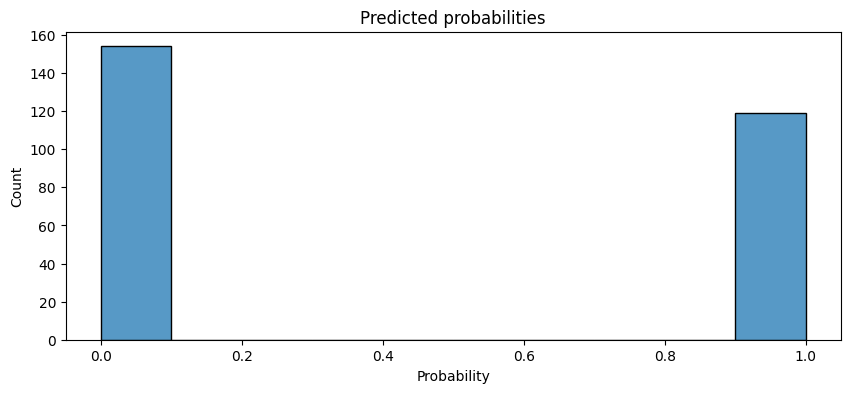

In [43]:
plt.figure(figsize=(10,4))
sns.histplot(preds)
plt.title('Predicted probabilities')
plt.xlabel('Probability')

Text(0.5, 1.0, 'Prediction distribution')

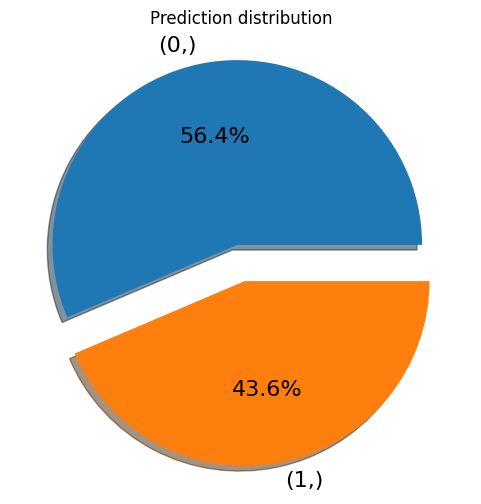

In [44]:
plt.figure(figsize=(6,6))
pd.DataFrame(preds).value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Prediction distribution")